In [33]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

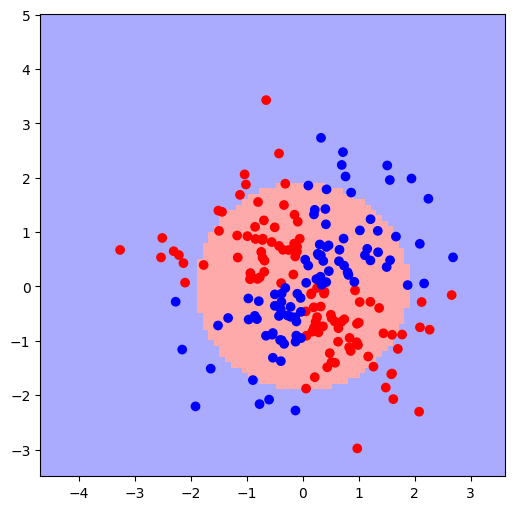

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
#        self.l1 = nn.Linear(input_size,nodes)
#        self.activation = nn.Tanh()

    def forward(self,x):
#        output = self.l1(x)
#        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)



In [35]:
#  Define the FFNN model
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x  # Raw logits for CrossEntropyLoss



In [36]:
# Define the training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1000):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
            val_loss = val_running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)
        
        # Optionally print progress
        if (epoch+1) % 100 == 0 or epoch == 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    return train_losses, val_losses



Processing dataset: xor

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.7030, Validation Loss: 0.6980
Epoch [100/1000], Training Loss: 0.6798, Validation Loss: 0.7120
Epoch [200/1000], Training Loss: 0.6760, Validation Loss: 0.7110
Epoch [300/1000], Training Loss: 0.6616, Validation Loss: 0.7016
Epoch [400/1000], Training Loss: 0.6084, Validation Loss: 0.6637
Epoch [500/1000], Training Loss: 0.5418, Validation Loss: 0.5959
Epoch [600/1000], Training Loss: 0.5156, Validation Loss: 0.5655
Epoch [700/1000], Training Loss: 0.5079, Validation Loss: 0.5586
Epoch [800/1000], Training Loss: 0.5056, Validation Loss: 0.5528
Epoch [900/1000], Training Loss: 0.5048, Validation Loss: 0.5551
Epoch [1000/1000], Training Loss: 0.5048, Validation Loss: 0.5567
Validation Accuracy for k=2: 0.7050

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.7046, Validation Loss: 0.6863
Epoch [100/1000], Training Loss: 0.6283, Validation Loss: 0.6774
Epoch [200/1000], Train

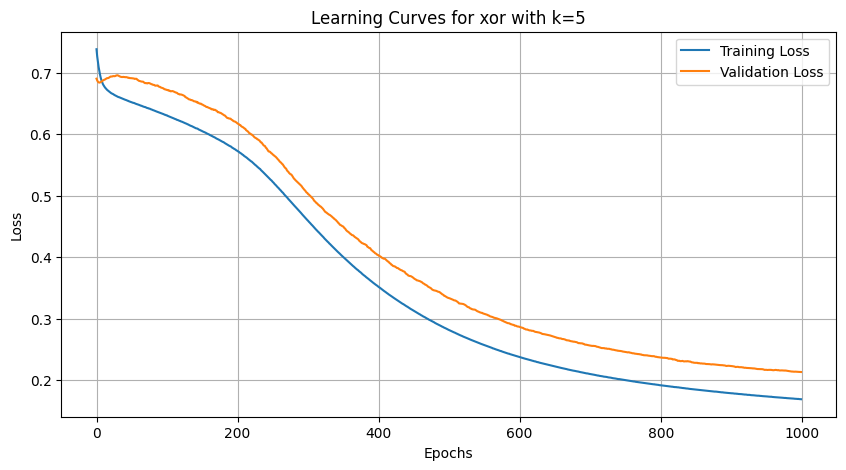

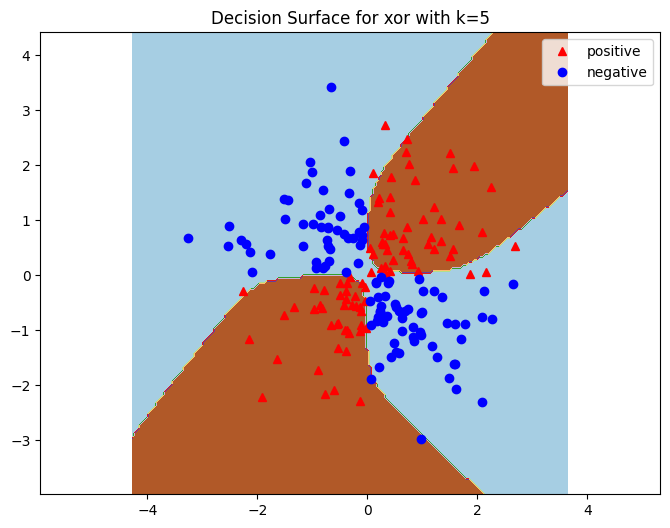


Processing dataset: center_surround

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.7113, Validation Loss: 0.7167
Epoch [100/1000], Training Loss: 0.6755, Validation Loss: 0.6531
Epoch [200/1000], Training Loss: 0.6456, Validation Loss: 0.6040
Epoch [300/1000], Training Loss: 0.5533, Validation Loss: 0.5126
Epoch [400/1000], Training Loss: 0.4727, Validation Loss: 0.4261
Epoch [500/1000], Training Loss: 0.4490, Validation Loss: 0.3909
Epoch [600/1000], Training Loss: 0.4397, Validation Loss: 0.3745
Epoch [700/1000], Training Loss: 0.4347, Validation Loss: 0.3631
Epoch [800/1000], Training Loss: 0.4304, Validation Loss: 0.3581
Epoch [900/1000], Training Loss: 0.4276, Validation Loss: 0.3536
Epoch [1000/1000], Training Loss: 0.4258, Validation Loss: 0.3489
Validation Accuracy for k=2: 0.8650

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.7498, Validation Loss: 0.7400
Epoch [100/1000], Training Loss: 0.6719, Validation Loss: 0.6553
Epoch [200/

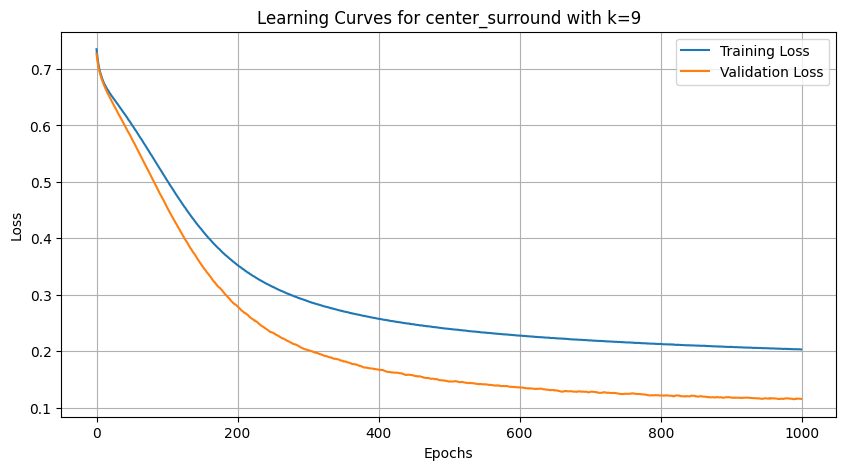

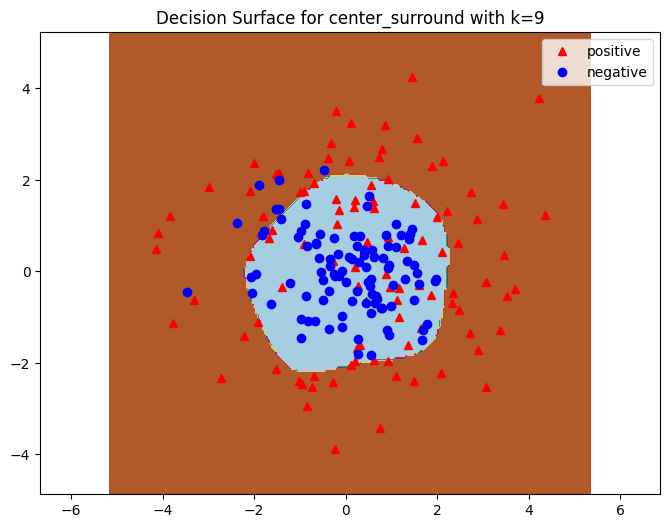


Processing dataset: two_gaussians

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.8091, Validation Loss: 0.7756
Epoch [100/1000], Training Loss: 0.1523, Validation Loss: 0.1166
Epoch [200/1000], Training Loss: 0.1294, Validation Loss: 0.0898
Epoch [300/1000], Training Loss: 0.1258, Validation Loss: 0.0837
Epoch [400/1000], Training Loss: 0.1245, Validation Loss: 0.0829
Epoch [500/1000], Training Loss: 0.1236, Validation Loss: 0.0819
Epoch [600/1000], Training Loss: 0.1236, Validation Loss: 0.0827
Epoch [700/1000], Training Loss: 0.1231, Validation Loss: 0.0824
Epoch [800/1000], Training Loss: 0.1230, Validation Loss: 0.0824
Epoch [900/1000], Training Loss: 0.1230, Validation Loss: 0.0826
Epoch [1000/1000], Training Loss: 0.1228, Validation Loss: 0.0822
Validation Accuracy for k=2: 0.9750

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.6495, Validation Loss: 0.6212
Epoch [100/1000], Training Loss: 0.1577, Validation Loss: 0.1273
Epoch [200/10

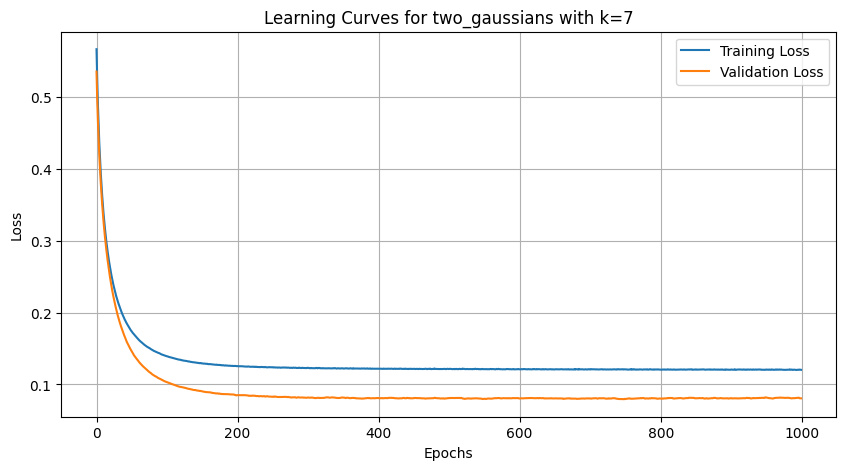

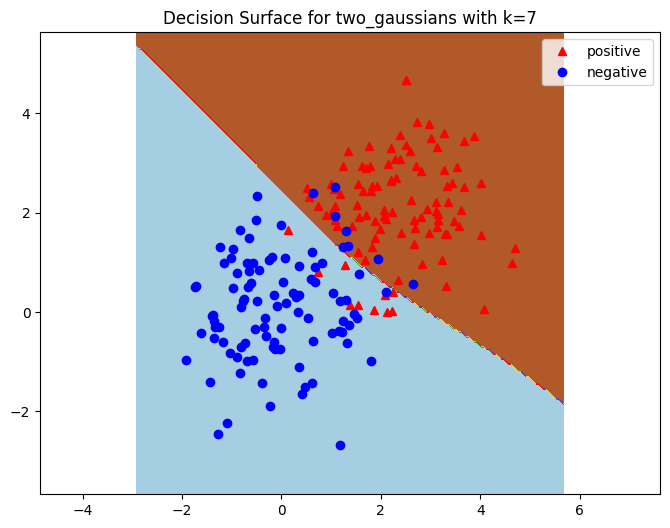


Processing dataset: spiral

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.5777, Validation Loss: 0.5792
Epoch [100/1000], Training Loss: 0.4926, Validation Loss: 0.5096
Epoch [200/1000], Training Loss: 0.4798, Validation Loss: 0.5833
Epoch [300/1000], Training Loss: 0.4863, Validation Loss: 0.5001
Epoch [400/1000], Training Loss: 0.4775, Validation Loss: 0.5089
Epoch [500/1000], Training Loss: 0.4740, Validation Loss: 0.5109
Epoch [600/1000], Training Loss: 0.4648, Validation Loss: 0.5026
Epoch [700/1000], Training Loss: 0.4572, Validation Loss: 0.4804
Epoch [800/1000], Training Loss: 0.4449, Validation Loss: 0.4747
Epoch [900/1000], Training Loss: 0.4349, Validation Loss: 0.4612
Epoch [1000/1000], Training Loss: 0.4267, Validation Loss: 0.4505
Validation Accuracy for k=2: 0.7350

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.8450, Validation Loss: 0.8333
Epoch [100/1000], Training Loss: 0.5290, Validation Loss: 0.5949
Epoch [200/1000], Tr

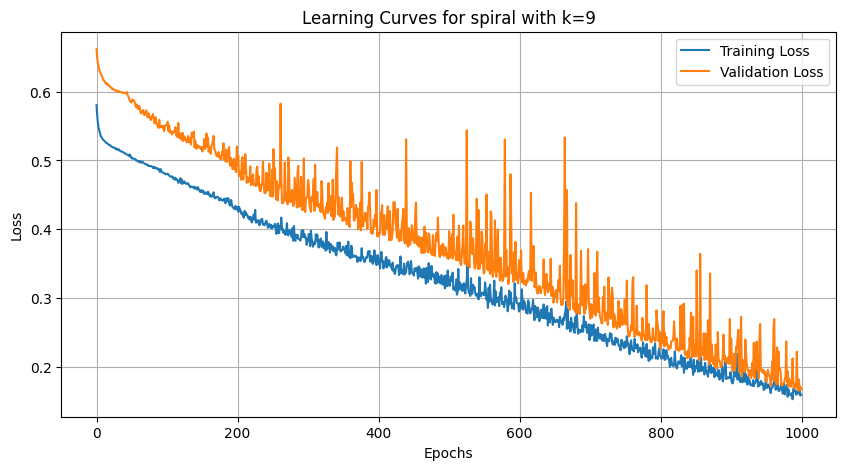

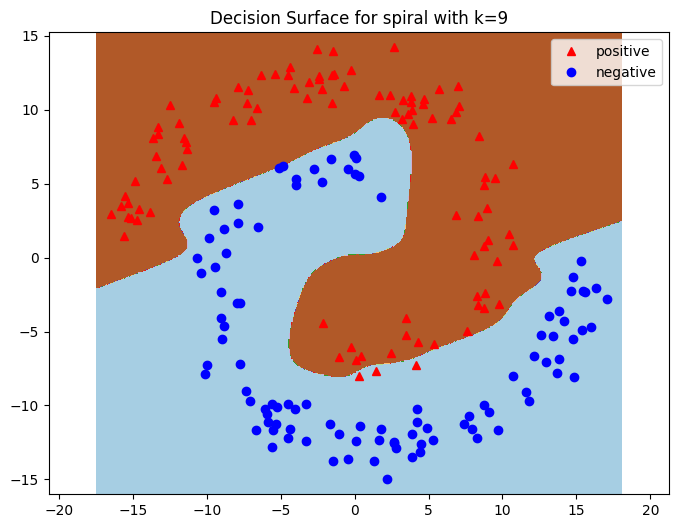

In [37]:
# Main execution loop for question 1
datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")
    
    # Read the datasets
    X_train, y_train, labels_train = read_data(dataset_name, 'train')
    X_test, y_test, labels_test = read_data(dataset_name, 'test')
    X_valid, y_valid, labels_valid = read_data(dataset_name, 'valid')
    
    # Remove bias term from all datasets if included
    if X_train.shape[1] == 3:  # If bias term is included
        X_train = X_train[:, 1:]  # Remove bias term
        X_valid = X_valid[:, 1:]  # Remove bias term
        X_test = X_test[:, 1:]    # Remove bias term

    
    # Convert to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long().squeeze()
    X_val_tensor = torch.from_numpy(X_valid).float()
    y_val_tensor = torch.from_numpy(y_valid).long().squeeze()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long().squeeze()
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the range of hidden layer sizes to experiment with
    k_values = [2, 3, 5, 7, 9]
    
    # Initialize variables to keep track of the best model
    best_val_loss = float('inf')
    best_k = None
    best_model = None
    
    # Dictionaries to store training and validation losses for each k
    train_losses_dict = {}
    val_losses_dict = {}
    val_accuracies_dict = {}
    
    # Iterate over different hidden layer sizes
    for k in k_values:
        print(f"\nTraining with hidden layer size k={k}")
        
        # Initialize the model
        model = FFNN(input_size=X_train_tensor.shape[1], hidden_size=k, output_size=2)
        
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # Number of epochs
        num_epochs = 1000
        
        # Train the model
        train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
        
        # Store the losses
        train_losses_dict[k] = train_losses
        val_losses_dict[k] = val_losses
        
        # After training, evaluate validation accuracy
        # (This has already been done inside train_model and printed)
        # To store it, you need to capture it during training
        # For simplicity, we'll compute it again here
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
        val_accuracy = correct / total
        val_accuracies_dict[k] = val_accuracy
        print(f"Validation Accuracy for k={k}: {val_accuracy:.4f}")
        
        # Check if this model is the best so far
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_k = k
            best_model = model

    # After evaluating all k's, print a summary table
    print(f"\nSummary of Results for dataset: {dataset_name}")
    print(f"{'k':<5}{'Val Loss':<15}{'Val Accuracy':<15}")
    for k in k_values:
        print(f"{k:<5}{val_losses_dict[k][-1]:<15.4f}{val_accuracies_dict[k]:<15.4f}")
    
    print(f"\nBest k for {dataset_name}: {best_k} with Validation Loss: {best_val_loss:.4f} and Validation Accuracy: {val_accuracies_dict[best_k]:.4f}")
    
    # Evaluate the best model on the test set
    best_model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
    test_accuracy = correct / total
    print(f"Test Accuracy for {dataset_name} with k={best_k}: {test_accuracy:.2f}")
    
    # (a) List hyperparameters
    print(f"\nHyperparameters for {dataset_name}:")
    print(f"Learning Rate: 0.01")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Hidden Layer Size (k): {best_k}")
    print(f"Activation Function: Tanh")
    print(f"Optimizer: SGD")
    
    # (b) Plot learning curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses_dict[best_k], label='Training Loss')
    plt.plot(val_losses_dict[best_k], label='Validation Loss')
    plt.title(f"Learning Curves for {dataset_name} with k={best_k}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (d) Plot decision boundary using provided plotting functions
    # Map labels for plotting (from class indices to -1/+1)
    y_test_np = y_test_tensor.numpy()
    X_test_np = X_test_tensor.numpy()
    labels_test_mapped = np.where(y_test_np == 0, -1, 1)

    
    def model_for_plotting(input_data):
        with torch.no_grad():
            inputs = torch.from_numpy(input_data).float()
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = np.where(predicted.numpy() == 0, -1, 1)
            return predicted_labels
    
    # Compute axis limits based on test data
    axis_limits = [X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1,
                   X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1]
    
    # Plot the decision surface
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model_for_plotting, axis_limits=axis_limits)
    
    # Overlay the test data
    plot_data(X_test_np, labels_test_mapped)
    
    plt.title(f"Decision Surface for {dataset_name} with k={best_k}")
    plt.show()


Processing dataset: xor

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.3009, Validation Loss: 0.2693
Epoch [100/1000], Training Loss: 0.2291, Validation Loss: 0.2467
Epoch [200/1000], Training Loss: 0.1901, Validation Loss: 0.2115
Epoch [300/1000], Training Loss: 0.1615, Validation Loss: 0.1914
Epoch [400/1000], Training Loss: 0.1579, Validation Loss: 0.1908
Epoch [500/1000], Training Loss: 0.1563, Validation Loss: 0.1905
Epoch [600/1000], Training Loss: 0.1551, Validation Loss: 0.1907
Epoch [700/1000], Training Loss: 0.1546, Validation Loss: 0.1910
Epoch [800/1000], Training Loss: 0.1543, Validation Loss: 0.1914
Epoch [900/1000], Training Loss: 0.1538, Validation Loss: 0.1907
Epoch [1000/1000], Training Loss: 0.1536, Validation Loss: 0.1916
Validation Accuracy for k=2: 0.6950

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.2486, Validation Loss: 0.2651
Epoch [100/1000], Training Loss: 0.1896, Validation Loss: 0.2106
Epoch [200/1000], Train

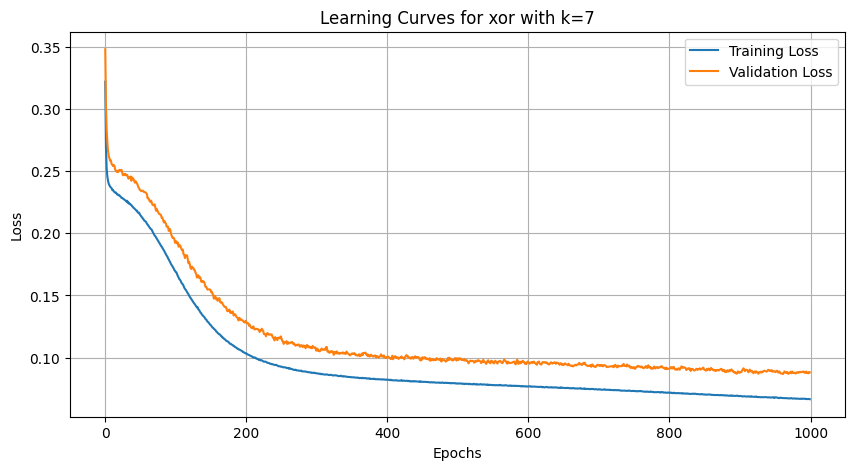

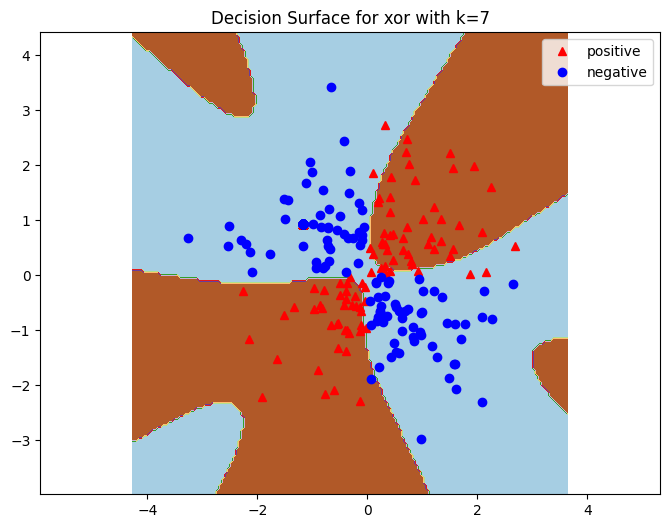


Processing dataset: center_surround

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.8100, Validation Loss: 0.7109
Epoch [100/1000], Training Loss: 0.2371, Validation Loss: 0.2260
Epoch [200/1000], Training Loss: 0.1453, Validation Loss: 0.1178
Epoch [300/1000], Training Loss: 0.1382, Validation Loss: 0.1048
Epoch [400/1000], Training Loss: 0.1381, Validation Loss: 0.1046
Epoch [500/1000], Training Loss: 0.1377, Validation Loss: 0.1063
Epoch [600/1000], Training Loss: 0.1376, Validation Loss: 0.1055
Epoch [700/1000], Training Loss: 0.1374, Validation Loss: 0.1067
Epoch [800/1000], Training Loss: 0.1369, Validation Loss: 0.1056
Epoch [900/1000], Training Loss: 0.1372, Validation Loss: 0.1053
Epoch [1000/1000], Training Loss: 0.1369, Validation Loss: 0.1053
Validation Accuracy for k=2: 0.8700

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.5343, Validation Loss: 0.4266
Epoch [100/1000], Training Loss: 0.1466, Validation Loss: 0.1243
Epoch [200/

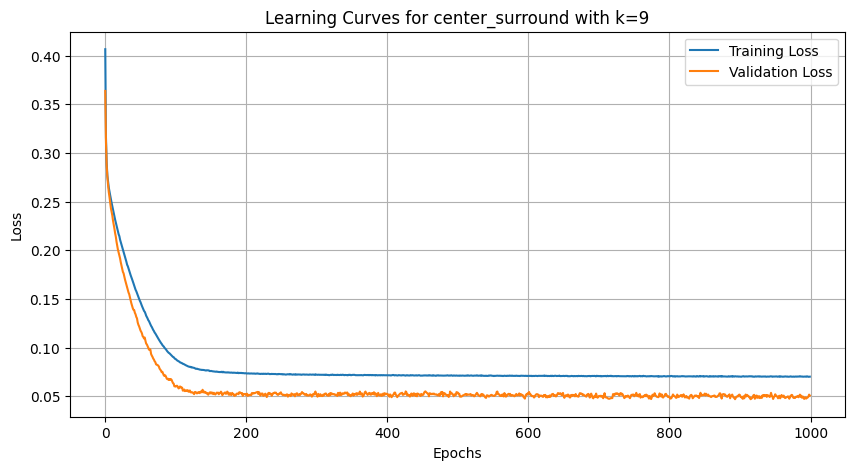

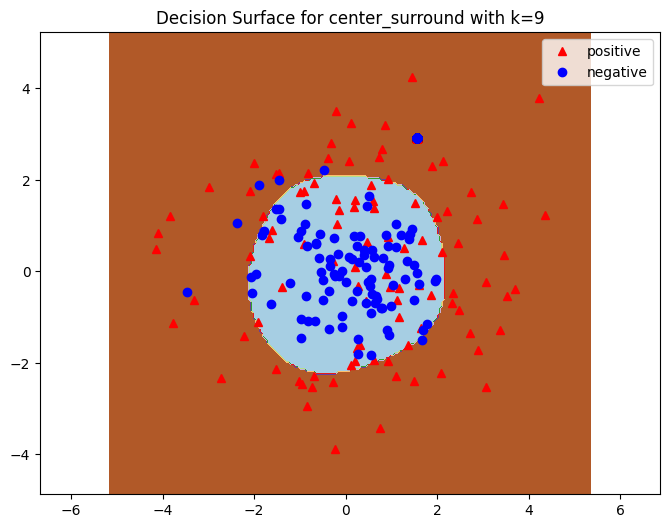


Processing dataset: two_gaussians

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.1843, Validation Loss: 0.1753
Epoch [100/1000], Training Loss: 0.0528, Validation Loss: 0.0411
Epoch [200/1000], Training Loss: 0.0470, Validation Loss: 0.0356
Epoch [300/1000], Training Loss: 0.0436, Validation Loss: 0.0324
Epoch [400/1000], Training Loss: 0.0416, Validation Loss: 0.0300
Epoch [500/1000], Training Loss: 0.0404, Validation Loss: 0.0288
Epoch [600/1000], Training Loss: 0.0394, Validation Loss: 0.0274
Epoch [700/1000], Training Loss: 0.0387, Validation Loss: 0.0268
Epoch [800/1000], Training Loss: 0.0382, Validation Loss: 0.0260
Epoch [900/1000], Training Loss: 0.0379, Validation Loss: 0.0256
Epoch [1000/1000], Training Loss: 0.0375, Validation Loss: 0.0252
Validation Accuracy for k=2: 0.9700

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.1975, Validation Loss: 0.1135
Epoch [100/1000], Training Loss: 0.0484, Validation Loss: 0.0371
Epoch [200/10

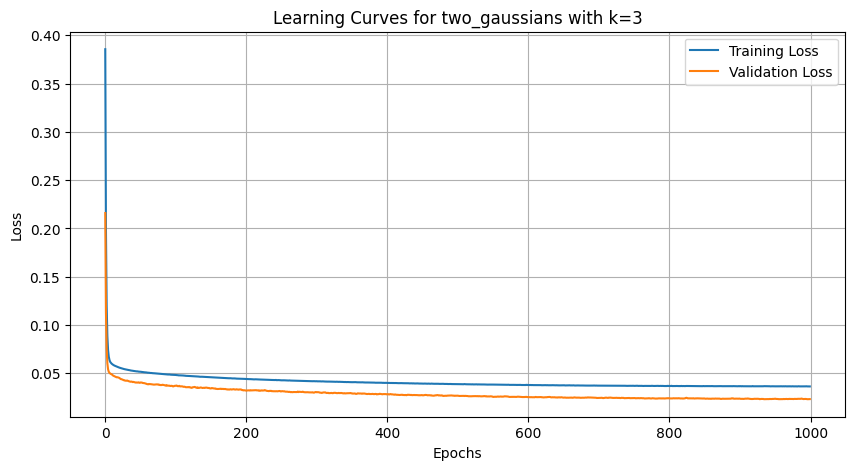

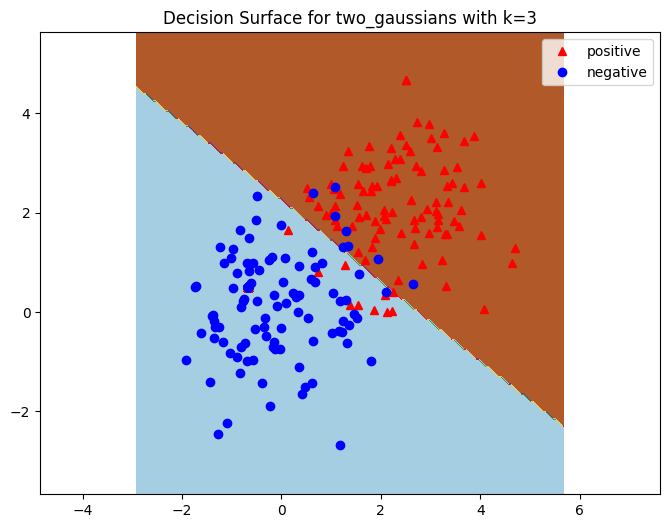


Processing dataset: spiral

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.5897, Validation Loss: 0.5716
Epoch [100/1000], Training Loss: 0.1834, Validation Loss: 0.2196
Epoch [200/1000], Training Loss: 0.1645, Validation Loss: 0.1816
Epoch [300/1000], Training Loss: 0.1554, Validation Loss: 0.1887
Epoch [400/1000], Training Loss: 0.1584, Validation Loss: 0.1678
Epoch [500/1000], Training Loss: 0.1522, Validation Loss: 0.1753
Epoch [600/1000], Training Loss: 0.1527, Validation Loss: 0.1684
Epoch [700/1000], Training Loss: 0.1559, Validation Loss: 0.1681
Epoch [800/1000], Training Loss: 0.1576, Validation Loss: 0.1674
Epoch [900/1000], Training Loss: 0.1558, Validation Loss: 0.1769
Epoch [1000/1000], Training Loss: 0.1585, Validation Loss: 0.1668
Validation Accuracy for k=2: 0.7350

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.2003, Validation Loss: 0.2252
Epoch [100/1000], Training Loss: 0.1599, Validation Loss: 0.1765
Epoch [200/1000], Tr

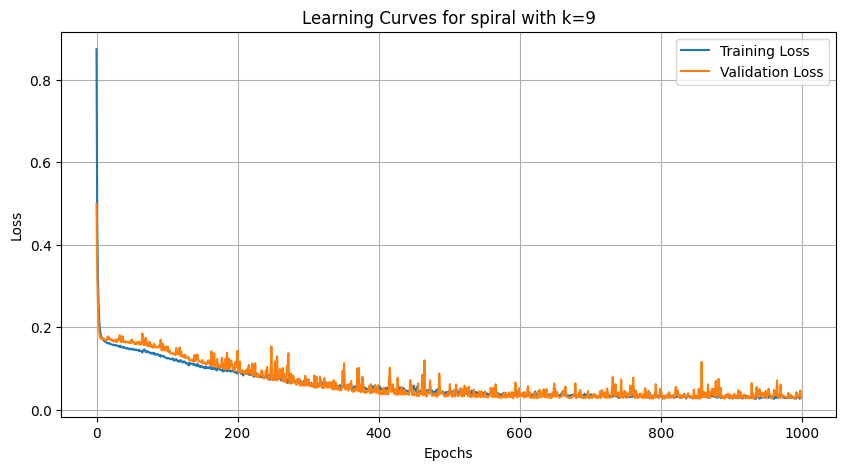

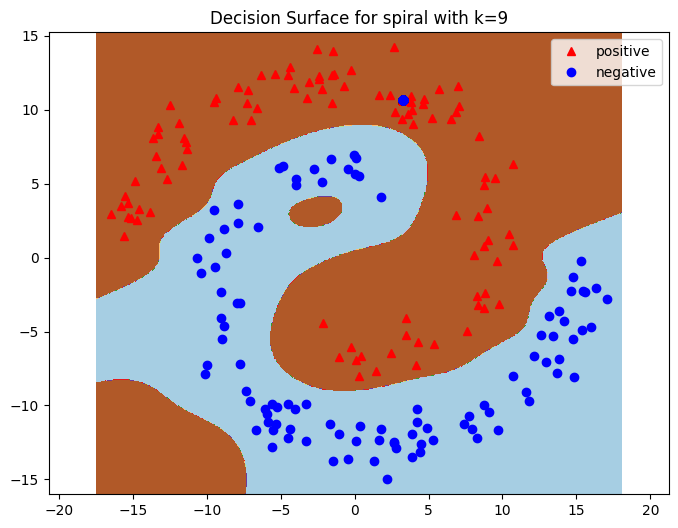

In [38]:
# Main execution loop for question 2
datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")
    
    # Read the datasets
    X_train, y_train, labels_train = read_data(dataset_name, 'train')
    X_test, y_test, labels_test = read_data(dataset_name, 'test')
    X_valid, y_valid, labels_valid = read_data(dataset_name, 'valid')
    
    # Remove bias term from all datasets if included
    if X_train.shape[1] == 3:  # If bias term is included
        X_train = X_train[:, 1:]  # Remove bias term
        X_valid = X_valid[:, 1:]  # Remove bias term
        X_test = X_test[:, 1:]    # Remove bias term

    
    # Convert to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    X_val_tensor = torch.from_numpy(X_valid).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    y_val_tensor = torch.from_numpy(y_valid).float()
    y_test_tensor = torch.from_numpy(y_test).float()
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the range of hidden layer sizes to experiment with
    k_values = [2, 3, 5, 7, 9]
    
    # Initialize variables to keep track of the best model
    best_val_loss = float('inf')
    best_k = None
    best_model = None
    
    # Dictionaries to store training and validation losses for each k
    train_losses_dict = {}
    val_losses_dict = {}
    val_accuracies_dict = {}
    
    # Iterate over different hidden layer sizes
    for k in k_values:
        print(f"\nTraining with hidden layer size k={k}")
        
        # Initialize the model
        model = FFNN(input_size=X_train_tensor.shape[1], hidden_size=k, output_size=1)

        
        # Define the loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # Number of epochs
        num_epochs = 1000
        
        # Train the model
        train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
        
        # Store the losses
        train_losses_dict[k] = train_losses
        val_losses_dict[k] = val_losses
        
        # After training, evaluate validation accuracy
        # (This has already been done inside train_model and printed)
        # To store it, you need to capture it during training
        # For simplicity, we'll compute it again here
        model.eval()
        correct = 0
        # total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                predicted = torch.round(outputs)
                # total += labels.size(0)
                correct += (predicted == labels).sum()
        val_accuracy = correct / len(val_dataset)
        val_accuracies_dict[k] = val_accuracy
        print(f"Validation Accuracy for k={k}: {val_accuracy:.4f}")
        
        # Check if this model is the best so far
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_k = k
            best_model = model

    # After evaluating all k's, print a summary table
    print(f"\nSummary of Results for dataset: {dataset_name}")
    print(f"{'k':<5}{'Val Loss':<15}{'Val Accuracy':<15}")
    for k in k_values:
        print(f"{k:<5}{val_losses_dict[k][-1]:<15.4f}{val_accuracies_dict[k]:<15.4f}")
    
    print(f"\nBest k for {dataset_name}: {best_k} with Validation Loss: {best_val_loss:.4f} and Validation Accuracy: {val_accuracies_dict[best_k]:.4f}")
    
    # Evaluate the best model on the test set
    best_model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f"Test Accuracy for {dataset_name} with k={best_k}: {test_accuracy:.2f}")
    
    # (a) List hyperparameters
    print(f"\nHyperparameters for {dataset_name}:")
    print(f"Learning Rate: 0.01")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Hidden Layer Size (k): {best_k}")
    print(f"Activation Function: Tanh")
    print(f"Optimizer: SGD")
    
    # (b) Plot learning curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses_dict[best_k], label='Training Loss')
    plt.plot(val_losses_dict[best_k], label='Validation Loss')
    plt.title(f"Learning Curves for {dataset_name} with k={best_k}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (d) Plot decision boundary using provided plotting functions
    # Map labels for plotting (from class indices to -1/+1)
    y_test_np = y_test_tensor.numpy()
    X_test_np = X_test_tensor.numpy()
    labels_test_mapped = np.where(y_test_np == 0, -1, 1)

    
    def model_for_plotting(input_data):
        with torch.no_grad():
            inputs = torch.from_numpy(input_data).float()
            outputs = best_model(inputs)
            predicted = torch.round(outputs)
            predicted_labels = np.where(predicted.numpy() == 0, -1, 1)
            return predicted_labels
    
    # Compute axis limits based on test data
    axis_limits = [X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1,
                   X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1]
    
    # Plot the decision surface
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model_for_plotting, axis_limits=axis_limits)
    
    # Overlay the test data
    plot_data(X_test_np, labels_test_mapped)
    
    plt.title(f"Decision Surface for {dataset_name} with k={best_k}")
    plt.show()

In [39]:
# Question 3: Implementing a Neural Network from Scratch

# Activation Functions and Their Derivatives
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(a):
    return 1 - np.square(a)

# Initialize Parameters
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)  # For reproducibility

    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2. / input_size)
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2. / hidden_size)
    b2 = np.zeros((output_size, 1))
    return W1, b1, W2, b2

# Forward Pass
def forward_pass(X, W1, b1, W2, b2, activation='tanh'):
    Z1 = np.dot(W1, X) + b1
    if activation == 'tanh':
        A1 = tanh(Z1)
    elif activation == 'sigmoid':
        A1 = sigmoid(Z1)
    else:
        raise ValueError("Unsupported activation function")
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = (Z1, A1, Z2, A2)
    return A2, cache

# Compute Loss
def compute_loss(Y, A2):
    m = Y.shape[1]
    epsilon = 1e-15  # To avoid log(0)
    loss = - (1/m) * np.sum(Y * np.log(A2 + epsilon) + (1 - Y) * np.log(1 - A2 + epsilon))
    return loss

# Backward Pass
def backward_pass(X, Y, cache, W2, activation='tanh'):
    Z1, A1, Z2, A2 = cache
    m = X.shape[1]

    # Output layer gradients
    dZ2 = A2 - Y  # (output_size, m)
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden layer gradients
    dA1 = np.dot(W2.T, dZ2)
    if activation == 'tanh':
        dZ1 = dA1 * tanh_derivative(A1)
    elif activation == 'sigmoid':
        dZ1 = dA1 * sigmoid_derivative(A1)
    else:
        raise ValueError("Unsupported activation function")
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dW1": dW1, "db1": db1,
                 "dW2": dW2, "db2": db2}
    return gradients

# Update Parameters
def update_parameters(W1, b1, W2, b2, gradients, learning_rate):
    W1 -= learning_rate * gradients["dW1"]
    b1 -= learning_rate * gradients["db1"]
    W2 -= learning_rate * gradients["dW2"]
    b2 -= learning_rate * gradients["db2"]
    return W1, b1, W2, b2

# Prediction Function
def predict(X, parameters, activation='tanh'):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    A2, _ = forward_pass(X, W1, b1, W2, b2, activation=activation)
    predictions = (A2 > 0.5).astype(int)
    return predictions

# Compute Accuracy
def compute_accuracy(predictions, Y):
    return np.mean(predictions == Y) * 100

# Training Function
def train_nn(X_train, Y_train, X_val, Y_val, hidden_size=3, learning_rate=0.1, num_epochs=1000, activation='tanh'):
    input_size = X_train.shape[0]
    output_size = Y_train.shape[0]

    # Initialize parameters
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Forward pass
        A2, cache = forward_pass(X_train, W1, b1, W2, b2, activation=activation)

        # Compute loss
        loss = compute_loss(Y_train, A2)

        # Backward pass
        gradients = backward_pass(X_train, Y_train, cache, W2, activation=activation)

        # Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, gradients, learning_rate)

        # Optionally, compute validation loss and print progress
        if epoch % 100 == 0 or epoch == 1:
            A2_val, _ = forward_pass(X_val, W1, b1, W2, b2, activation=activation)
            val_loss = compute_loss(Y_val, A2_val)
            print(f"Epoch {epoch}: Training Loss = {loss:.6f}, Validation Loss = {val_loss:.6f}")

    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2}
    return parameters

In [40]:
# Main execution loop for question 3
for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")

    # Load your data using the existing read_data function
    name = dataset_name
    mode_train = 'train'
    mode_val = 'valid'
    mode_test = 'test'

    X_train, Y_train, _ = read_data(name, mode_train)  # X_train: (m, n)
    X_val, Y_val, _ = read_data(name, mode_val)
    X_test, Y_test, _ = read_data(name, mode_test)

    # Preprocess data
    # No need to remove columns if data is already clean
    # Transpose to get shape (input_size, m)
    X_train = X_train[:, 1:].T  # Shape: (input_size, m)
    X_val = X_val[:, 1:].T
    X_test = X_test[:, 1:].T


    Y_train = Y_train.T  # Shape: (1, m)
    Y_val = Y_val.T
    Y_test = Y_test.T

    # Set hyperparameters
    hidden_size = 3  # Adjust as needed
    learning_rate = 0.1
    num_epochs = 1000
    activation = 'tanh'

    # Adjust hyperparameters for specific datasets if needed
    if dataset_name == 'spiral':
        hidden_size = 10
        num_epochs = 5000
        activation = 'tanh'

    # Train the neural network
    parameters = train_nn(X_train, Y_train, X_val, Y_val,
                          hidden_size=hidden_size,
                          learning_rate=learning_rate,
                          num_epochs=num_epochs,
                          activation=activation)

    # Predict on test set
    predictions = predict(X_test, parameters, activation=activation)
    accuracy = compute_accuracy(predictions, Y_test)
    print(f"Test Accuracy on {dataset_name}: {accuracy:.2f}%")
    
  


Processing dataset: xor
Epoch 1: Training Loss = 0.833434, Validation Loss = 0.796297
Epoch 100: Training Loss = 0.659587, Validation Loss = 0.705806
Epoch 200: Training Loss = 0.620857, Validation Loss = 0.673749
Epoch 300: Training Loss = 0.577383, Validation Loss = 0.627617
Epoch 400: Training Loss = 0.546130, Validation Loss = 0.593739
Epoch 500: Training Loss = 0.526853, Validation Loss = 0.573571
Epoch 600: Training Loss = 0.513582, Validation Loss = 0.560360
Epoch 700: Training Loss = 0.498400, Validation Loss = 0.546200
Epoch 800: Training Loss = 0.470618, Validation Loss = 0.521191
Epoch 900: Training Loss = 0.430125, Validation Loss = 0.484977
Epoch 1000: Training Loss = 0.390668, Validation Loss = 0.449540
Test Accuracy on xor: 80.00%

Processing dataset: center_surround
Epoch 1: Training Loss = 0.837030, Validation Loss = 0.751621
Epoch 100: Training Loss = 0.600155, Validation Loss = 0.586169
Epoch 200: Training Loss = 0.525302, Validation Loss = 0.496638
Epoch 300: Train

In [51]:
# Part 4: Implementing a Neural Network with PyTorch
# Define the training function

def norm_regularizer(weight_matrix):
    return torch.norm(weight_matrix, p=2)

def orthogonality_regularizer(weight_matrix):
    # Compute weight_matrix * weight_matrix^T
    dot_product_matrix = torch.mm(weight_matrix, weight_matrix.t())
    # Zero out the diagonal elements to ignore self-dot products
    dot_product_matrix.fill_diagonal_(0)
    # Compute the sum of absolute values of off-diagonal elements
    loss = torch.sum(torch.abs(dot_product_matrix))
    return loss

def loss_with_regularization(outputs, labels, weight_matrix, lambda_l2=0.01, lambda_orthog=0.1):
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)
    
    l2_loss = lambda_l2 * norm_regularizer(weight_matrix)
    orthog_loss = lambda_orthog * orthogonality_regularizer(weight_matrix)
    
    total_loss = loss + l2_loss + orthog_loss
    return total_loss

def train_reg_model(model, optimizer, train_loader, val_loader, num_epochs=1000, lambda_l2=0.01, lambda_orthog=0.1):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # Compute loss with regularization
            loss = loss_with_regularization(outputs, labels, model.fc1.weight, lambda_l2, lambda_orthog)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_with_regularization(outputs, labels, model.fc1.weight, lambda_l2, lambda_orthog)
                val_running_loss += loss.item() * inputs.size(0)
            val_loss = val_running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)
        
        # Optionally print progress
        if (epoch+1) % 100 == 0 or epoch == 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.6f}, Validation Loss: {val_loss:.6f}')
        
    return train_losses, val_losses




Processing dataset: xor

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.775226, Validation Loss: 0.740690
Epoch [100/1000], Training Loss: 0.669116, Validation Loss: 0.711910
Epoch [200/1000], Training Loss: 0.648840, Validation Loss: 0.696189
Epoch [300/1000], Training Loss: 0.627367, Validation Loss: 0.675229
Epoch [400/1000], Training Loss: 0.605770, Validation Loss: 0.657114
Epoch [500/1000], Training Loss: 0.587977, Validation Loss: 0.642264
Epoch [600/1000], Training Loss: 0.575560, Validation Loss: 0.633256
Epoch [700/1000], Training Loss: 0.567339, Validation Loss: 0.626142
Epoch [800/1000], Training Loss: 0.561884, Validation Loss: 0.623565
Epoch [900/1000], Training Loss: 0.557606, Validation Loss: 0.623235
Epoch [1000/1000], Training Loss: 0.555040, Validation Loss: 0.619363
Validation Accuracy for k=2: 0.6350

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.941391, Validation Loss: 0.853626
Epoch [100/1000], Training Loss: 0.68923

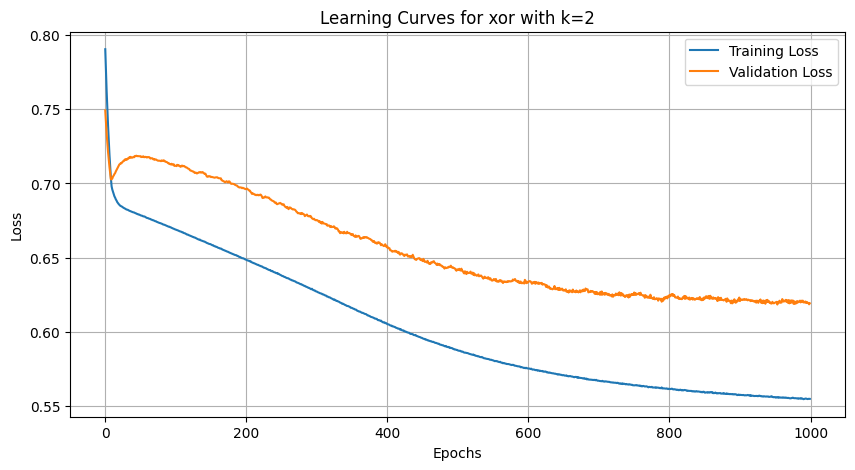

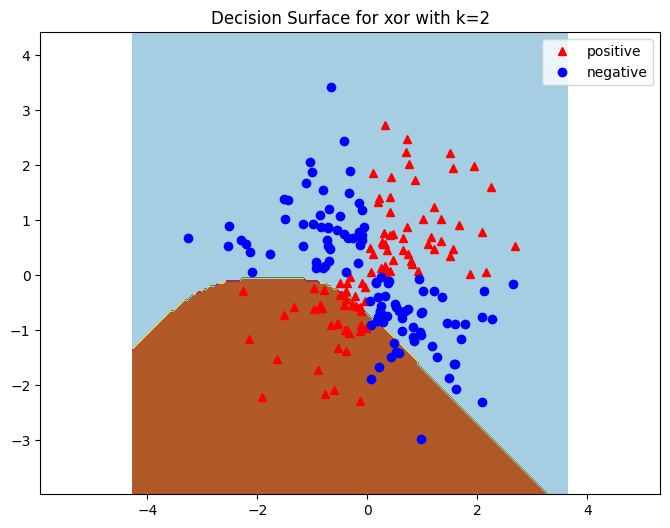


Processing dataset: center_surround

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.785703, Validation Loss: 0.778805
Epoch [100/1000], Training Loss: 0.623810, Validation Loss: 0.598814
Epoch [200/1000], Training Loss: 0.578293, Validation Loss: 0.554420
Epoch [300/1000], Training Loss: 0.550906, Validation Loss: 0.525203
Epoch [400/1000], Training Loss: 0.534854, Validation Loss: 0.507977
Epoch [500/1000], Training Loss: 0.525076, Validation Loss: 0.496651
Epoch [600/1000], Training Loss: 0.518597, Validation Loss: 0.489779
Epoch [700/1000], Training Loss: 0.513920, Validation Loss: 0.486042
Epoch [800/1000], Training Loss: 0.510571, Validation Loss: 0.481461
Epoch [900/1000], Training Loss: 0.507977, Validation Loss: 0.480195
Epoch [1000/1000], Training Loss: 0.506083, Validation Loss: 0.477443
Validation Accuracy for k=2: 0.7950

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.841855, Validation Loss: 0.847754
Epoch [100/1000], Training L

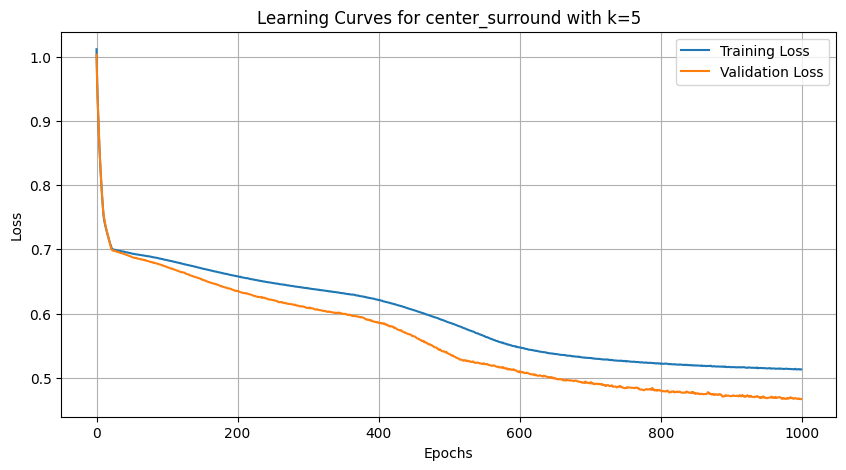

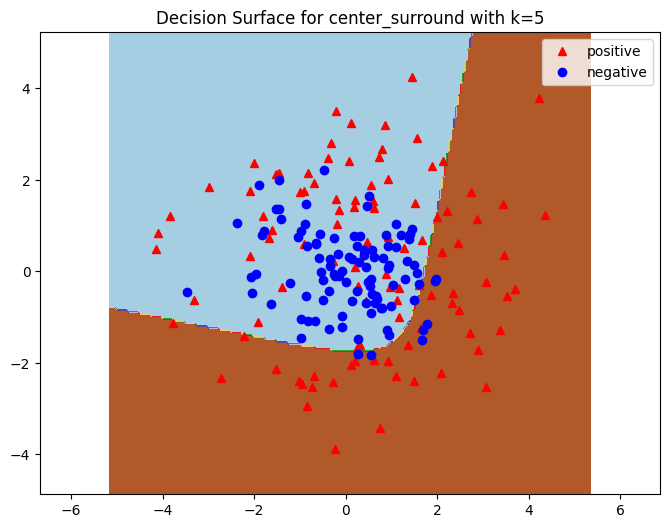


Processing dataset: two_gaussians

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.725418, Validation Loss: 0.717643
Epoch [100/1000], Training Loss: 0.205338, Validation Loss: 0.169961
Epoch [200/1000], Training Loss: 0.157561, Validation Loss: 0.117575
Epoch [300/1000], Training Loss: 0.148580, Validation Loss: 0.107579
Epoch [400/1000], Training Loss: 0.144856, Validation Loss: 0.102865
Epoch [500/1000], Training Loss: 0.142384, Validation Loss: 0.100232
Epoch [600/1000], Training Loss: 0.140462, Validation Loss: 0.100040
Epoch [700/1000], Training Loss: 0.139605, Validation Loss: 0.098651
Epoch [800/1000], Training Loss: 0.137599, Validation Loss: 0.099027
Epoch [900/1000], Training Loss: 0.137328, Validation Loss: 0.097732
Epoch [1000/1000], Training Loss: 0.135604, Validation Loss: 0.096454
Validation Accuracy for k=2: 0.9750

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.972956, Validation Loss: 0.943096
Epoch [100/1000], Training Los

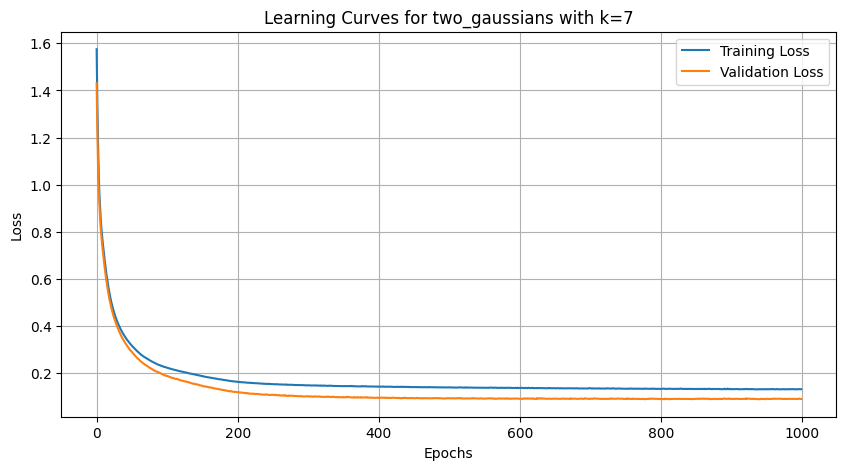

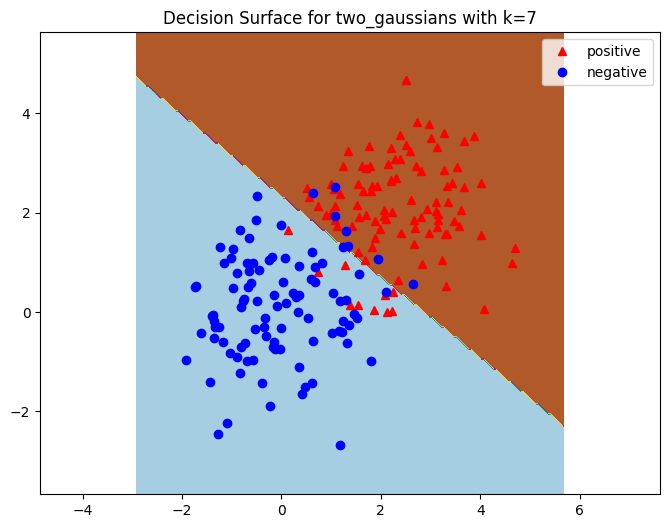


Processing dataset: spiral

Training with hidden layer size k=2
Epoch [2/1000], Training Loss: 0.722087, Validation Loss: 0.716800
Epoch [100/1000], Training Loss: 0.509235, Validation Loss: 0.533756
Epoch [200/1000], Training Loss: 0.483487, Validation Loss: 0.517130
Epoch [300/1000], Training Loss: 0.499414, Validation Loss: 0.510847
Epoch [400/1000], Training Loss: 0.476347, Validation Loss: 0.507792
Epoch [500/1000], Training Loss: 0.480195, Validation Loss: 0.496421
Epoch [600/1000], Training Loss: 0.494004, Validation Loss: 0.499910
Epoch [700/1000], Training Loss: 0.484010, Validation Loss: 0.538845
Epoch [800/1000], Training Loss: 0.476546, Validation Loss: 0.493040
Epoch [900/1000], Training Loss: 0.473918, Validation Loss: 0.485598
Epoch [1000/1000], Training Loss: 0.461360, Validation Loss: 0.480162
Validation Accuracy for k=2: 0.7400

Training with hidden layer size k=3
Epoch [2/1000], Training Loss: 0.709326, Validation Loss: 0.734892
Epoch [100/1000], Training Loss: 0.49

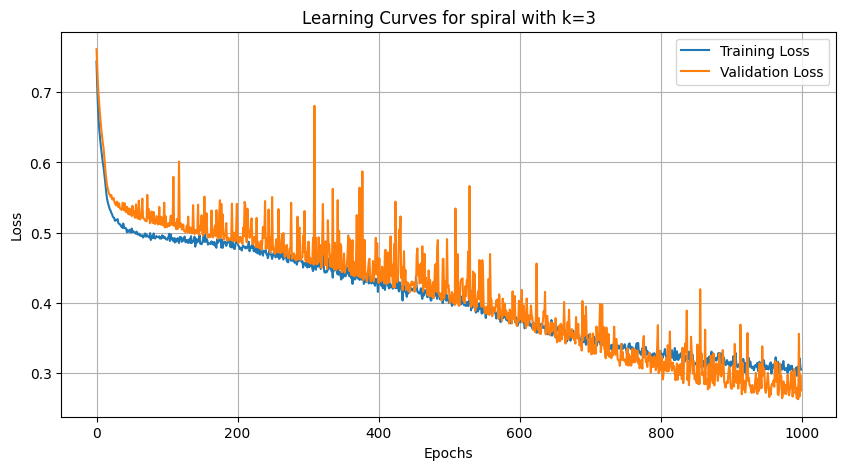

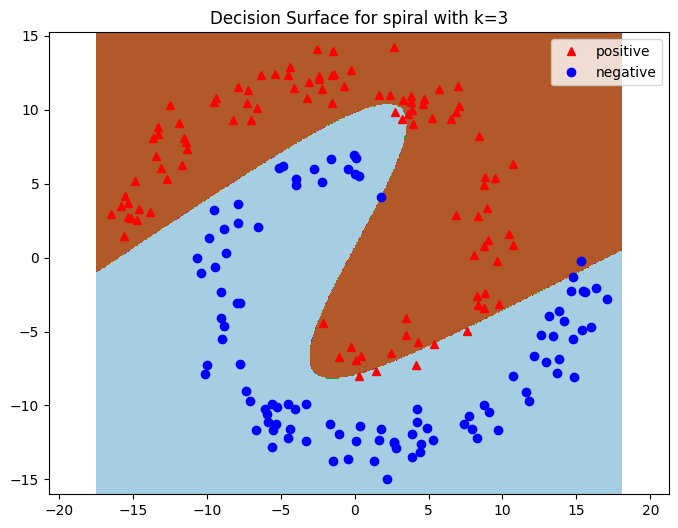

In [55]:
# Main execution loop for question 4
datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']

for dataset_name in datasets:
    print(f"\nProcessing dataset: {dataset_name}")
    
    # Read the datasets
    X_train, y_train, labels_train = read_data(dataset_name, 'train')
    X_test, y_test, labels_test = read_data(dataset_name, 'test')
    X_valid, y_valid, labels_valid = read_data(dataset_name, 'valid')
    
    # Remove bias term from all datasets if included
    if X_train.shape[1] == 3:  # If bias term is included
        X_train = X_train[:, 1:]  # Remove bias term
        X_valid = X_valid[:, 1:]  # Remove bias term
        X_test = X_test[:, 1:]    # Remove bias term

    
    # Convert to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long().squeeze()
    X_val_tensor = torch.from_numpy(X_valid).float()
    y_val_tensor = torch.from_numpy(y_valid).long().squeeze()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long().squeeze()
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define the range of hidden layer sizes to experiment with
    k_values = [2, 3, 5, 7, 9]
    
    # Initialize variables to keep track of the best model
    best_val_loss = float('inf')
    best_k = None
    best_model = None
    
    # Dictionaries to store training and validation losses for each k
    train_losses_dict = {}
    val_losses_dict = {}
    val_accuracies_dict = {}
    
    # Iterate over different hidden layer sizes
    for k in k_values:
        print(f"\nTraining with hidden layer size k={k}")
        
        # Initialize the model
        model = FFNN(input_size=X_train_tensor.shape[1], hidden_size=k, output_size=2)
        
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        
        # Number of epochs
        num_epochs = 1000
        
        # Train the model
        train_losses, val_losses = train_reg_model(model, optimizer, train_loader, val_loader, lambda_l2=0.01, lambda_orthog=0.1)
        
        # Store the losses
        train_losses_dict[k] = train_losses
        val_losses_dict[k] = val_losses
        
        # After training, evaluate validation accuracy
        # (This has already been done inside train_model and printed)
        # To store it, you need to capture it during training
        # For simplicity, we'll compute it again here
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
        val_accuracy = correct / total
        val_accuracies_dict[k] = val_accuracy
        print(f"Validation Accuracy for k={k}: {val_accuracy:.4f}")
        
        # Check if this model is the best so far
        val_loss = val_losses[-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_k = k
            best_model = model

    # After evaluating all k's, print a summary table
    print(f"\nSummary of Results for dataset: {dataset_name}")
    print(f"{'k':<5}{'Val Loss':<15}{'Val Accuracy':<15}")
    for k in k_values:
        print(f"{k:<5}{val_losses_dict[k][-1]:<15.4f}{val_accuracies_dict[k]:<15.4f}")
    
    print(f"\nBest k for {dataset_name}: {best_k} with Validation Loss: {best_val_loss:.4f} and Validation Accuracy: {val_accuracies_dict[best_k]:.4f}")
    
    # Evaluate the best model on the test set
    best_model.eval()
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
    test_accuracy = correct / total
    print(f"Test Accuracy for {dataset_name} with k={best_k}: {test_accuracy:.2f}")
    
    # (a) List hyperparameters
    print(f"\nHyperparameters for {dataset_name}:")
    print(f"Learning Rate: 0.01")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Hidden Layer Size (k): {best_k}")
    print(f"Activation Function: Tanh")
    print(f"Optimizer: SGD")
    
    # (b) Plot learning curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses_dict[best_k], label='Training Loss')
    plt.plot(val_losses_dict[best_k], label='Validation Loss')
    plt.title(f"Learning Curves for {dataset_name} with k={best_k}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (d) Plot decision boundary using provided plotting functions
    # Map labels for plotting (from class indices to -1/+1)
    y_test_np = y_test_tensor.numpy()
    X_test_np = X_test_tensor.numpy()
    labels_test_mapped = np.where(y_test_np == 0, -1, 1)

    
    def model_for_plotting(input_data):
        with torch.no_grad():
            inputs = torch.from_numpy(input_data).float()
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = np.where(predicted.numpy() == 0, -1, 1)
            return predicted_labels
    
    # Compute axis limits based on test data
    axis_limits = [X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1,
                   X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1]
    
    # Plot the decision surface
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model_for_plotting, axis_limits=axis_limits)
    
    # Overlay the test data
    plot_data(X_test_np, labels_test_mapped)
    
    plt.title(f"Decision Surface for {dataset_name} with k={best_k}")
    plt.show()